In [30]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import boxcox

sns.set(style="ticks", color_codes=True)

%matplotlib inline

# Introduction

Using seasonally-aggregated input data generated in notebook 01_generate_features, carry out exploratory data analysis to help identify potentially important relationships. This includes:

* Time series of potentially important explanatory variables
* Correlation coefficients
* Scatterplot matrices

Data matrices for each of the four target variables (lake TP, chl-a, cyanobacteria and colour) are written to csv for use in the feature importance analysis.

Used to inform the selection of variables to include in the GBN (together with feature importance analysis and process knowledge).

Created by Leah JB. Part of the ERA4CS WATExR project.

# User input

In [31]:
# User input
met_source = "metno"  # Only choice available here

# File paths to input data
seasonal_features_fpath = (
    r"../Data/DataMatrices/Seasonal_6monthly/Vansjø_seasonal_data_1Season_Van2_%s.csv"
    % met_source
)
# Paths to folders for saving output

# Folder to write csvs for use in feature importance analysis
out_folder = r"../Data/DataMatrices/Seasonal_6monthly/split_by_variable"

# Correlation coefficients
corr_coeff_folder = r"../Data/CorrelationCoeffs"

# Graphs
graph_outfolder = r"../Figures"

# Read in seasonally-aggregated data

In [32]:
season_df = pd.read_csv(seasonal_features_fpath, index_col=0, parse_dates=True)
season_df.head()

,Pptn,Temp,Wind_speed,Q,TP_catch,chl-a_lake,TP_lake,colour_lake,CyanoBiovol,Rain_day,...,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,TP_lake_prevSummer,colour_lake_prevSummer,chl-a_lake_prevSummer,Temp_prevSummer,CyanoBiovol_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-04-30,NaN,-3.086262,2.848333,NaN,130.0,3.971429,45.250000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-10-31,579.570268,13.090170,3.341848,87.710170,86.4,16.080130,43.573016,NaN,NaN,83.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-04-30,244.503965,-0.893721,3.413812,69.853277,NaN,NaN,NaN,NaN,NaN,39.0,...,16.0,33.0,80.0,57.0,27.0,43.573016,NaN,16.08013,13.090170,NaN
1981-10-31,494.730157,12.599971,3.488587,61.463318,NaN,8.331250,28.833333,NaN,NaN,61.0,...,5.0,41.0,68.0,64.0,38.0,43.573016,NaN,16.08013,13.090170,NaN
1982-04-30,366.125943,-1.877038,3.360221,96.428880,69.0,1.100000,46.250000,NaN,NaN,60.0,...,17.0,30.0,68.0,68.0,35.0,28.833333,NaN,8.33125,12.599971,NaN


Note that the number of samples per month was low until 2005, so the monthly and seasonal means based on them are much less accurate. Much more intense sampling from 2005 until 2012. Any way of giving these seasons higher weight when fitting the BN I wonder?

As a result of this, the apparently high monthly mean chl-a in 2004, which is a real outlier, looks a bit suspicious as it's only based on 3 data points. Compared to around 8 in 2005, maybe more. **Would be good to also look at number of samples per season per year.**

The imbalance in the number of samples per year for lake colour is particularly massive, due partly to the patching of the two different data sources (MOVAR vs. NIVA). Apparent trends over time could easily be due to changes in sampling frequency.

# Time series plots

## Summer growing season time series

In [33]:
# vars to keep and plot (aside from Season)
vars_to_plot = [
    'TP_lake',
    'chl-a_lake',
    'CyanoBiovol',
    'colour_lake',
    'Pptn',
    'Wind_speed',
    'Temp',
    'Q',
    'TP_catch',
    ]

# Select data to be plotted
df_plot = season_df.loc[:, vars_to_plot+['Season']]  # Drop all but variables to keep
df_plot = df_plot.loc[df_plot['Season'] == 'summ', ~df_plot.columns.isin(['season'])]

# Add year column and reindex using year
df_plot['year'] = df_plot.index.year
df_plot.set_index('year', inplace=True)

df_plot.tail()

,TP_lake,chl-a_lake,CyanoBiovol,colour_lake,Pptn,Wind_speed,Temp,Q,TP_catch,Season
year,,,,,,,,,,
2014,20.300000,12.600000,0.283,41.863636,626.732204,3.519890,14.484634,73.748707,75.937500,summ
2015,24.250000,14.925000,0.233,52.833333,686.892707,3.771196,12.687234,85.027104,81.000000,summ
2016,18.750000,9.590909,0.166,52.000000,408.035955,3.755978,14.026004,22.024397,63.615385,summ
2017,19.666667,12.866667,0.258,42.000000,570.221295,3.710326,13.366517,67.758768,77.928571,summ
2018,18.666667,10.741667,0.614,36.333333,312.809003,3.968478,15.453903,10.900915,NaN,summ


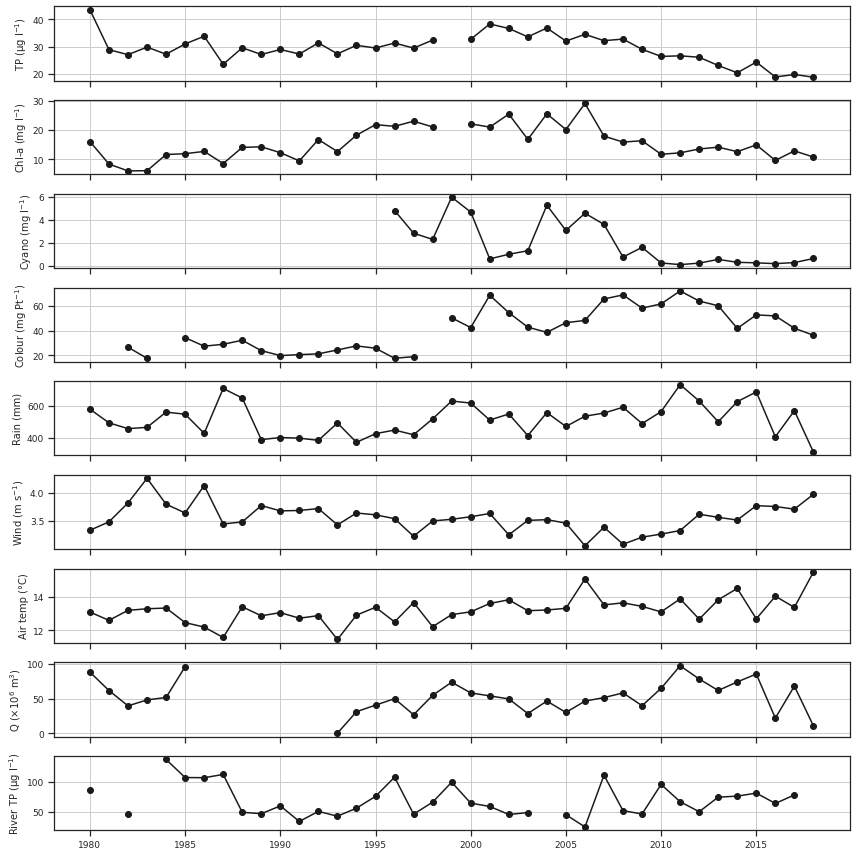

In [34]:
# Dictionary for renaming variable names
label_dict = {
    "chl-a_lake": "Chl-a (mg l$^{-1}$)",
    "colour_lake": "Colour (mg Pt$^{-1}$)",
    "CyanoBiovol": "Cyano (mg l$^{-1}$)",
    "Pptn": "Rain (mm)",
    "Temp": "Air temp (°C)",
    "TP_lake": "TP (µg l$^{-1}$)",
    "Wind_speed": "Wind (m s$^{-1}$)",
    "Season": "Season",
    "Q": "Q (×10$^6$ m$^3$)",
    "TP_catch": "River TP (µg l$^{-1}$)",
}

ax = df_plot.plot(
    subplots=True, figsize=(12, 12), grid=True, marker="o", legend=False, color="k"
)
for i, var in enumerate(vars_to_plot):
    ax[i].xaxis.grid(True, which="minor", linestyle="-", linewidth=0.5)
    ax[i].set_ylabel(label_dict[var], fontsize=10)
    ax[i].set_xlabel("")
    ax[i].tick_params(axis="both", which="major", labelsize=9)

plt.tight_layout()
plt.savefig(
    os.path.join(
        graph_outfolder,
        "Timeseries_seasonal_interesting_vars",
        "Vansjø_6M_timeseries_forPaper_%s.png" % met_source,
    )
)
plt.savefig(
    os.path.join(
        graph_outfolder,
        "Timeseries_seasonal_interesting_vars",
        "Vansjø_6M_timeseries_forPaper_%s.eps" % met_source,
    )
)

## Summer and winter season time series

In winter 2000-2001 there was a large flood event, widely thought to have caused wash-in of nutrients to the lake, and cyanobacterial blooms and bathing bans for much of the period 2001-2007. However, on the time series plot below, we can see peak precipitation and discharge in winter 2001, but cyanobacteria if anything decreased for a couple of years after the high Q.

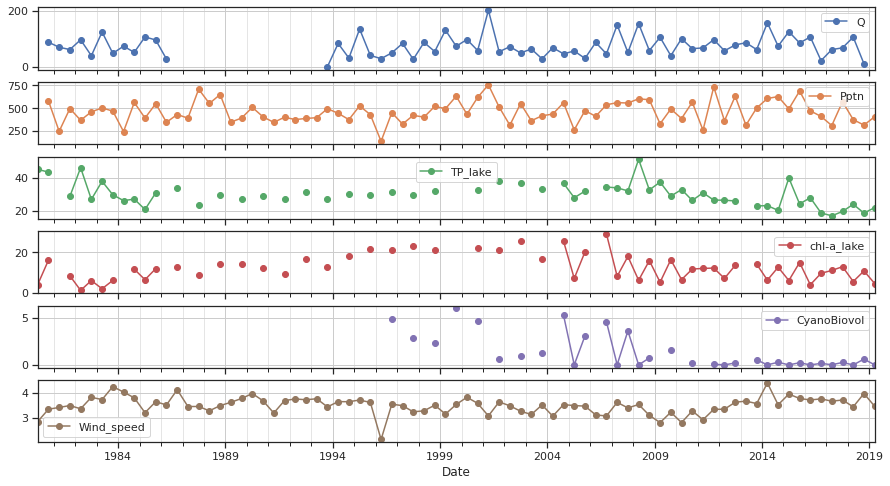

In [35]:
vars_to_plot = ["Q", "Pptn", "TP_lake", "chl-a_lake", "CyanoBiovol", "Wind_speed"]
ax = season_df.loc[:, vars_to_plot].plot(
    subplots=True, figsize=(15, 8), grid=True, marker="o"
)
for i, var in enumerate(vars_to_plot):
    ax[i].xaxis.grid(True, which="minor", linestyle="-", linewidth=0.5)
ax[1].legend(loc="upper right")

# Split into separate matrices for the 4 possible response variables & look at correlations

In [36]:
season_slice = 'summ'  # one of 'all', 'wint', 'summ'
if season_slice in ['wint', 'summ']:
    season_var_df = season_df.loc[season_df['Season'] == season_slice, :]

print(len(season_df))

79


In [37]:
# Plotting function
def plot_scattermatrix(season_df, vars_for_scatterplot, var):
    """
    Custom scattermatrix function.
    Input: df containing data to plot
    vars_for_scatterplot: list of column names from within df that you want to include
    var: dependent variable name, just used for file naming
    """

    rename_dict = {
    "TP_lake": "TP",
    "TP_lake_prevSummer": "TP (PS)",
    "Wind_under_Q0.2": "Wind<P20",
    "Wind_speed_lag1": "Wind speed (W)",
    "Wind_speed": "Wind speed",
    "Q": "Q",
    'chl-a_lake': 'Chl-a',
    'chl-a_lake_prevSummer': 'Chl-a (PS)',
    'Wind_over_Q0.6': 'Wind>P60',
    'Temp': 'Temp',
    'CyanoBiovol': 'Cyano',
    'CyanoBiovol_prevSummer': 'Cyano (PS)',
    'colour_lake': 'Colour',
    'Wind_over_Q0.6_lag1': 'Wind>P60 (W)',
    'colour_lake_prevSummer': 'Colour (PS)',
    'Pptn': 'Rain sum',
    'Temp_prevSummer': 'Temp (PS)',
    'cyano_bxcx': 'Cyano (boxcox)'
    }

    figsize = len(vars_for_scatterplot) * 1.5 + 1

    plot_df = season_df.loc[:, vars_for_scatterplot]
    plot_df = plot_df.rename(columns=rename_dict)

    pd.plotting.scatter_matrix(
        plot_df,
        diagonal="kde",
        color="black",
        density_kwds={"color": "black"},
        alpha=0.6,
        s=150,
        figsize=(figsize, figsize),
    )
    plt.tight_layout()

    # Save as png
    fpath = os.path.join(graph_outfolder, "Scatterplots", "seasonal_6M_scattermatrix_%s_%s.png" % (var, met_source))
    plt.savefig(fpath, dpi=300)

    # Save as eps for publishing
    fpath = os.path.join(graph_outfolder, "Scatterplots", "seasonal_6M_scattermatrix_%s_%s.eps" % (var, met_source))
    plt.savefig(fpath)

    plt.show()

In [38]:
sorted(season_df.columns)

['CyanoBiovol',
 'CyanoBiovol_prevSummer',
 'Pptn',
 'Pptn_intense',
 'Pptn_intense_lag1',
 'Pptn_lag1',
 'Q',
 'Q_lag1',
 'Rain_day',
 'Rain_day_lag1',
 'Season',
 'TP_catch',
 'TP_lake',
 'TP_lake_prevSummer',
 'Temp',
 'Temp_lag1',
 'Temp_prevSummer',
 'Temp_subzero',
 'Wind_over_Q0.6',
 'Wind_over_Q0.6_lag1',
 'Wind_over_Q0.8',
 'Wind_over_Q0.8_lag1',
 'Wind_speed',
 'Wind_speed_lag1',
 'Wind_under_Q0.2',
 'Wind_under_Q0.2_lag1',
 'Wind_under_Q0.4',
 'Wind_under_Q0.4_lag1',
 'chl-a_lake',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_prevSummer']

## Lake TP

In [39]:
# First, lake TP concentration is the dependent variable.
cols_to_drop = [
 'CyanoBiovol',
 'CyanoBiovol_prevSummer',
 'chl-a_lake',
 'chl-a_lake_prevSummer',
 'colour_lake',
 'colour_lake_prevSummer',
 'Temp_subzero',
    ]

season_df_TP = season_var_df.drop(cols_to_drop, axis=1)
print(len(season_df_TP))

# Drop any rows where TP_lake is a NaN
season_df_TP.dropna(subset=['TP_lake'], inplace=True)
print(len(season_df_TP))
season_df_TP.head()

39
38


,Pptn,Temp,Wind_speed,Q,TP_catch,TP_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,...,Wind_speed_lag1,Q_lag1,Rain_day_lag1,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,TP_lake_prevSummer,Temp_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1980-10-31,579.570268,13.090170,3.341848,87.710170,86.400000,43.573016,83.0,16.0,33.0,80.0,...,2.848333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1981-10-31,494.730157,12.599971,3.488587,61.463318,NaN,28.833333,61.0,17.0,30.0,68.0,...,3.413812,69.853277,39.0,5.0,41.0,68.0,64.0,38.0,43.573016,13.090170
1982-10-31,458.474789,13.190846,3.818478,39.515126,45.500000,26.988095,64.0,18.0,19.0,52.0,...,3.360221,96.428880,60.0,10.0,47.0,82.0,69.0,41.0,28.833333,12.599971
1983-10-31,466.631052,13.283700,4.247283,47.977834,NaN,29.781250,63.0,14.0,13.0,49.0,...,3.728177,124.071782,68.0,14.0,44.0,72.0,77.0,48.0,26.988095,13.190846
1984-10-31,561.472065,13.326957,3.796739,51.510902,137.664286,27.158333,76.0,21.0,10.0,53.0,...,4.027473,73.566317,45.0,5.0,35.0,64.0,90.0,58.0,29.781250,13.283700


In [40]:
X = season_df_TP.drop(['TP_lake'], axis=1)
y = season_df_TP['TP_lake']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_TP_%s.csv' % met_source))

Wind_speed_lag1        -0.397344
Wind_over_Q0.6         -0.351162
Wind_over_Q0.6_lag1    -0.321224
Wind_speed             -0.298707
Wind_over_Q0.8_lag1    -0.238533
Temp_lag1              -0.211108
Wind_over_Q0.8         -0.183918
Temp                   -0.157684
TP_catch               -0.103351
Temp_prevSummer        -0.022888
Q_lag1                 -0.014968
Pptn                    0.012091
Rain_day                0.053810
Rain_day_lag1           0.055671
Pptn_intense            0.063169
Pptn_intense_lag1       0.076212
Q                       0.106530
Pptn_lag1               0.138523
Wind_under_Q0.4_lag1    0.321338
Wind_under_Q0.4         0.388342
Wind_under_Q0.2_lag1    0.443253
Wind_under_Q0.2         0.512255
TP_lake_prevSummer      0.648018
dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


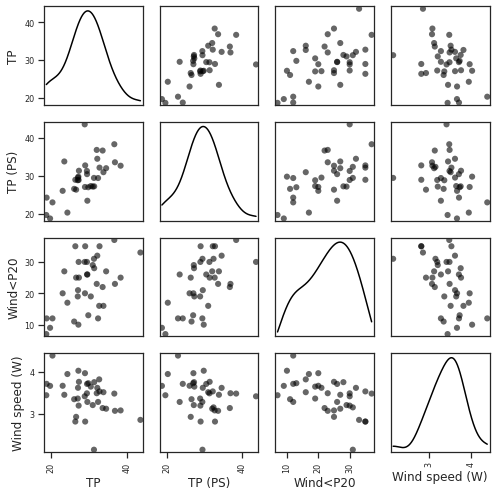

In [41]:
vars_for_scatterplot = [
    "TP_lake",
    "TP_lake_prevSummer",
    "Wind_under_Q0.2",
    "Wind_speed_lag1",
    # "Wind_speed",
    # "Q"
]
plot_scattermatrix(season_var_df, vars_for_scatterplot, 'TP')

## Lake chl-a

In [42]:
# 2) chl-a concentration
cols_to_drop = [
 'CyanoBiovol',
 'CyanoBiovol_prevSummer',
 'Temp_subzero'
    ]

season_df_lake_chla = season_var_df.drop(cols_to_drop,axis=1)
print(len(season_df_lake_chla))

# Drop any rows where explanatory variable value is a NaN
season_df_lake_chla.dropna(subset=['chl-a_lake'], inplace=True)
print(len(season_df_lake_chla))
# monthly_df_lake_chla.head()

39
38


In [43]:
X = season_df_lake_chla.drop(['chl-a_lake'], axis=1)
y = season_df_lake_chla['chl-a_lake']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_chla_%s.csv' % met_source))
corr_df.sort_values()

Wind_over_Q0.6           -0.511171
Wind_speed               -0.509073
Wind_over_Q0.8           -0.488407
Wind_over_Q0.6_lag1      -0.292697
TP_catch                 -0.277073
Wind_over_Q0.8_lag1      -0.235561
Wind_speed_lag1          -0.224530
Q                        -0.118536
Rain_day                 -0.056026
Q_lag1                   -0.045299
Pptn                      0.004497
Pptn_intense_lag1         0.023696
colour_lake_prevSummer    0.056162
Pptn_lag1                 0.061462
Pptn_intense              0.065821
Rain_day_lag1             0.069899
Temp_prevSummer           0.115109
Temp_lag1                 0.154622
colour_lake               0.156121
Wind_under_Q0.4_lag1      0.156643
Wind_under_Q0.2_lag1      0.162138
Temp                      0.219597
Wind_under_Q0.2           0.294241
TP_lake_prevSummer        0.314649
Wind_under_Q0.4           0.411067
TP_lake                   0.577868
chl-a_lake_prevSummer     0.649868
dtype: float64


Wind_over_Q0.6           -0.511171
Wind_speed               -0.509073
Wind_over_Q0.8           -0.488407
Wind_over_Q0.6_lag1      -0.292697
TP_catch                 -0.277073
Wind_over_Q0.8_lag1      -0.235561
Wind_speed_lag1          -0.224530
Q                        -0.118536
Rain_day                 -0.056026
Q_lag1                   -0.045299
Pptn                      0.004497
Pptn_intense_lag1         0.023696
colour_lake_prevSummer    0.056162
Pptn_lag1                 0.061462
Pptn_intense              0.065821
Rain_day_lag1             0.069899
Temp_prevSummer           0.115109
Temp_lag1                 0.154622
colour_lake               0.156121
Wind_under_Q0.4_lag1      0.156643
Wind_under_Q0.2_lag1      0.162138
Temp                      0.219597
Wind_under_Q0.2           0.294241
TP_lake_prevSummer        0.314649
Wind_under_Q0.4           0.411067
TP_lake                   0.577868
chl-a_lake_prevSummer     0.649868
dtype: float64

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


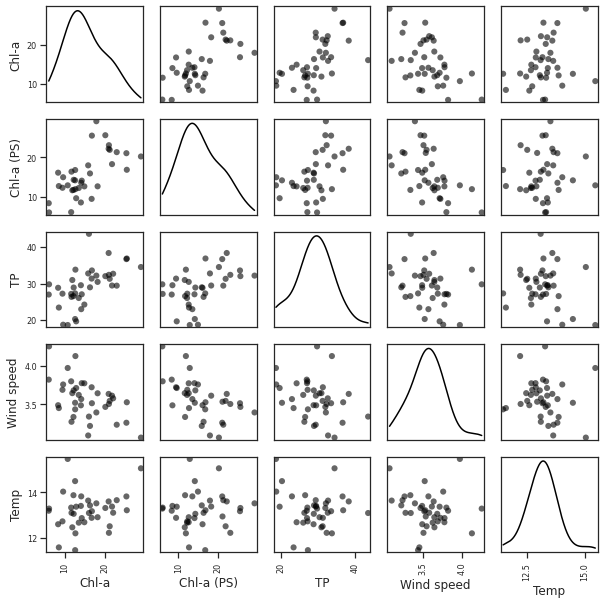

In [44]:
vars_for_scatterplot = ['chl-a_lake',
                        'chl-a_lake_prevSummer',
                        'TP_lake',
                        'Wind_speed',
                        'Temp']

plot_scattermatrix(season_var_df, vars_for_scatterplot, 'chl-a')

## Max cyanobacterial biovolume

In [45]:
# cols to drop:
cols_to_drop = [
 'Temp_subzero'
    ]

season_df_cyano = season_var_df.drop(cols_to_drop, axis=1)
print(len(season_df_cyano))

# Drop any rows where explanatory var value is a NaN
season_df_cyano.dropna(subset=['CyanoBiovol'], inplace=True)
print(len(season_df_cyano))

39
23


In [46]:
X = season_df_cyano.drop(['CyanoBiovol'], axis=1)
y = season_df_cyano['CyanoBiovol']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_cyano_%s.csv' % met_source))

colour_lake_prevSummer   -0.497767
colour_lake              -0.440540
Wind_over_Q0.6_lag1      -0.383631
Wind_speed_lag1          -0.314211
Temp_prevSummer          -0.261873
Wind_over_Q0.6           -0.249123
Wind_over_Q0.8_lag1      -0.238124
Wind_speed               -0.202043
Pptn_intense_lag1        -0.200102
Temp                     -0.198354
Q_lag1                   -0.176347
Q                        -0.162922
Pptn_lag1                -0.111964
Temp_lag1                -0.090535
Wind_over_Q0.8           -0.084422
Rain_day                 -0.071290
Rain_day_lag1            -0.040312
Pptn                     -0.033442
Pptn_intense              0.128758
TP_catch                  0.166735
Wind_under_Q0.4           0.232004
Wind_under_Q0.4_lag1      0.268457
Wind_under_Q0.2           0.302548
Wind_under_Q0.2_lag1      0.354052
TP_lake_prevSummer        0.491975
CyanoBiovol_prevSummer    0.554195
chl-a_lake_prevSummer     0.557810
TP_lake                   0.576964
chl-a_lake          

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


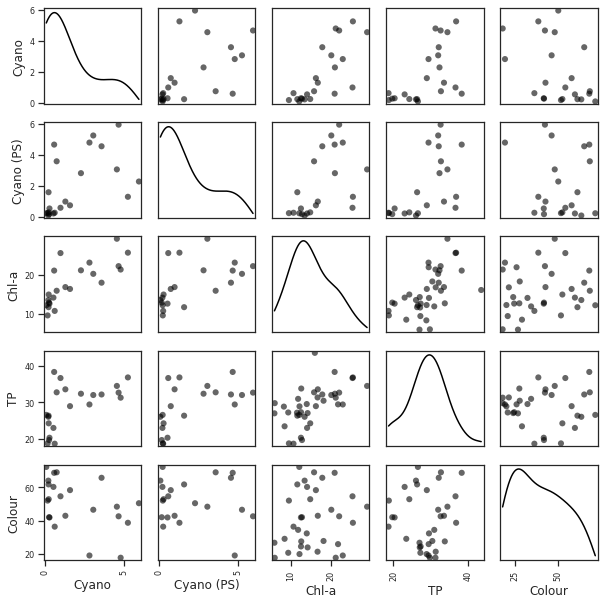

In [47]:
vars_for_scatterplot = ['CyanoBiovol',
                        'CyanoBiovol_prevSummer',
                        'chl-a_lake',
                        'TP_lake',
                        'colour_lake',
                       ]

plot_scattermatrix(season_var_df, vars_for_scatterplot, 'cyano')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


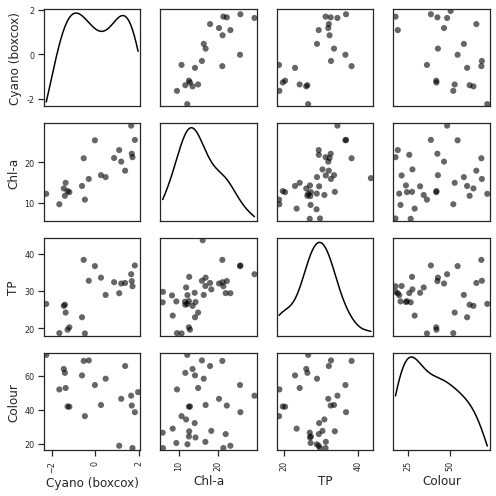

In [48]:
plot_df = season_var_df.copy()
plot_df["cyano_bxcx"] = boxcox(season_var_df["CyanoBiovol"].values, lmbda=0.1)

vars_for_scatterplot = ["cyano_bxcx", "chl-a_lake", "TP_lake", "colour_lake"]

plot_scattermatrix(plot_df, vars_for_scatterplot, "cyano_bxcx")

## Lake colour

In [49]:
# Drop all ecological-related stuff

cols_to_drop = [
    "CyanoBiovol",
    "CyanoBiovol_prevSummer",
    "Season",
    "TP_catch",
    "TP_lake",
    "TP_lake_prevSummer",
    "chl-a_lake",
    "chl-a_lake_prevSummer",
    "Temp_subzero",
]

season_df_lakeColour = season_var_df.drop(cols_to_drop, axis=1)
print(len(season_df_lakeColour))

# Drop any rows where response var is a NaN
season_df_lakeColour.dropna(subset=["colour_lake"], inplace=True)
print(len(season_df_lakeColour))
season_df_lakeColour.head()

39
35


,Pptn,Temp,Wind_speed,Q,colour_lake,Rain_day,Pptn_intense,Wind_under_Q0.2,Wind_under_Q0.4,Wind_over_Q0.6,...,Wind_speed_lag1,Q_lag1,Rain_day_lag1,Pptn_intense_lag1,Wind_under_Q0.2_lag1,Wind_under_Q0.4_lag1,Wind_over_Q0.6_lag1,Wind_over_Q0.8_lag1,colour_lake_prevSummer,Temp_prevSummer
Date,,,,,,,,,,,,,,,,,,,,,
1982-10-31,458.474789,13.190846,3.818478,39.515126,26.666667,64.0,18.0,19.0,52.0,82.0,...,3.360221,96.428880,60.0,10.0,47.0,82.0,69.0,41.0,NaN,12.599971
1983-10-31,466.631052,13.283700,4.247283,47.977834,17.625000,63.0,14.0,13.0,49.0,94.0,...,3.728177,124.071782,68.0,14.0,44.0,72.0,77.0,48.0,26.666667,13.190846
1985-10-31,548.374613,12.465199,3.644022,95.430528,34.404762,75.0,18.0,29.0,72.0,72.0,...,3.203315,106.745818,62.0,12.0,50.0,83.0,63.0,32.0,NaN,13.326957
1986-10-31,429.271284,12.202530,4.122283,NaN,27.472222,64.0,13.0,16.0,47.0,95.0,...,3.512155,27.737338,53.0,10.0,53.0,78.0,70.0,46.0,34.404762,12.465199
1987-10-31,708.329005,11.587689,3.451630,NaN,29.027778,85.0,21.0,27.0,69.0,62.0,...,3.450276,NaN,60.0,9.0,49.0,82.0,67.0,43.0,27.472222,12.202530


In [50]:
X = season_df_lakeColour.drop(['colour_lake'], axis=1)
y = season_df_lakeColour['colour_lake']
corr_df = X.corrwith(y, method='pearson')
print(corr_df.sort_values())
corr_df.sort_values().to_csv(os.path.join(corr_coeff_folder, 'corr_coeffs_colour_%s.csv' % met_source))

Wind_over_Q0.8           -0.469205
Wind_speed               -0.458943
Wind_over_Q0.6           -0.446843
Wind_over_Q0.6_lag1      -0.266339
Wind_over_Q0.8_lag1      -0.255410
Wind_under_Q0.2_lag1     -0.167840
Wind_speed_lag1          -0.152769
Rain_day_lag1             0.137185
Wind_under_Q0.4_lag1      0.141319
Wind_under_Q0.2           0.151229
Temp_lag1                 0.165608
Pptn_lag1                 0.223417
Pptn_intense_lag1         0.259167
Wind_under_Q0.4           0.297364
Q_lag1                    0.321284
Temp                      0.350542
Rain_day                  0.383785
Temp_prevSummer           0.427524
Q                         0.445643
Pptn_intense              0.459151
Pptn                      0.526432
colour_lake_prevSummer    0.854938
dtype: float64


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


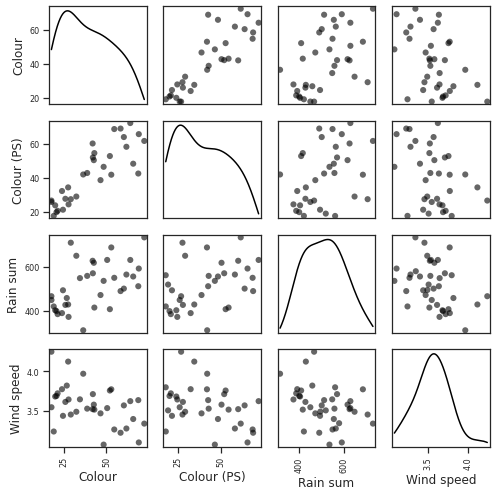

In [51]:
vars_for_scatterplot = [
    "colour_lake",
    "colour_lake_prevSummer",
    "Pptn",
    "Wind_speed"
]

plot_scattermatrix(season_var_df, vars_for_scatterplot, "colour")

# Write output csvs split by variable for use in feature importance analysis

In [52]:
basin = "Van2"
season_df_TP.to_csv(os.path.join(out_folder, 'dataMatrix_seasonal_TP_%s_%s.csv' % (season_slice,basin)), index_label='Date')
season_df_lake_chla.to_csv(os.path.join(out_folder, 'dataMatrix_seasonal_Chl-a_%s_%s.csv' % (season_slice,basin)), index_label='Date')
season_df_cyano.to_csv(os.path.join(out_folder, 'dataMatrix_seasonal_CyanoBiovol_%s_%s.csv' % (season_slice,basin)), index_label='Date')
season_df_lakeColour.to_csv(os.path.join(out_folder, 'dataMatrix_seasonal_colour_lake_%s_%s.csv' % (season_slice,basin)), index_label='Date')